# WEAT (Word Embedding Association Test)

This notebook aims to explain the [WEAT](https://arxiv.org/pdf/1608.07187) (Word Embedding Association Test), giving a surface level explanation of how it works, and how it can be applied to fairness assessments in the financial domain, using [WEFE](https://github.com/dccuchile/wefe) (Word Embedding Fairness Evalution).

**Cosine Similarity:**

Cosine Similarity measures the association  between two vectors. In the context of NLP these two vectors are word embeddings, thus cosine similarity can measure the association between words in a vector space.  Generally speaking we would expect words of similar semantic meaning to occupy similar vector spaces, e.g. man, boy, guy etc. We would also expect word associations to be similarly distances from eachother, e.g. man - king should be roughly the same distance as women - queen.

The cosine similarity between two word vectors
$\textbf{a}$ and $\textbf{b}$ is defined as:

$$
\cos(\textbf{a},\textbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|}
$$

We want to usually check the association of words w towards some group of words containing a set of attributes. For example, we want to look at the association with the word “Professor” with ethnic groups such as “Black”, “White” or “Asian”.  The similarity is:

$$
s(\textbf{w}, A) = \frac{1}{n} \sum_{\textbf{a} \in A} \cos(\textbf{w}, \textbf{a})
$$

Where $\textbf{w}$ is the word of interest (i.e. Professor) and 

$$
A = \{\mathbf{a}_1, \mathbf{a}_2, \ldots, \mathbf{a}_n\}
$$

is a set containing sensitive word embeddings such as different ethnicities.

**WEAT:**

The Word Embedding Association Test compares sets of target words $X$ and $Y$ with sets of attributes $A$ and $B$ with the hypothesis that words in set $X$ are associated with words in set $A$ and likewise words in set $Y$ are associated with words in set $B$. For example:
$$
X = \{\text{man}, \text{male}, \text{boy}\}
$$
$$
Y = \{\text{woman}, \text{female}, \text{girl}\}
$$
$$
A = \{\text{doctor}, \text{professor}, \text{manager}\}
$$
$$
B = \{\text{nurse}, \text{teacher}, \text{assistant}\}
$$

and we hypothesise that our model may associate the words "male" with "professor" and "female" with "teacher" instead, as a measure of bias. Using cosine similarity for a word $\textbf{w}$ against words $\textbf{a},\textbf{b}$ in sets $A,B$ we have:

$$
s(\textbf{w}, A, B) = \frac{1}{n} \sum_{\textbf{a} \in A} \cos(\textbf{w}, \textbf{a}) - \frac{1}{n} \sum_{\textbf{b} \in B} \cos(\textbf{w}, \textbf{b})
$$

where $n$ is the number of embedded attributes (i.e. instances of a feature) in each set. To quantify the bias, we use the [effect size](https://en.wikipedia.org/wiki/Effect_size):
$$
d(X, Y, A, B) = \frac{\frac{1}{n} \sum_{x \in X} s(x, A, B) - \frac{1}{n} \sum_{y \in Y} s(y, A, B)}{\sigma_{w \in X \cup Y} s(w, A, B)}
$$

A positive effect size confirms that the words in set $X$ have some association with words in set $A$ and likewise words in $Y$ are associated with words in $B$.

To determine the statistical significance of biases measured in these tests, the authors use the statistic:
$$
s(X,Y,A,B) = \sum_{x \in X} s(x,A,B) - \sum_{y \in Y} s(y,A,B)
$$

for a permutation test with partitions $(X_i,Y_i)$ of $X \cup Y$:
$$
p = P_r[s(X_i,Y_i,A,B) > s(X,Y,A,B)]
$$

We first download word embeddings. Here we are using [GloVe](https://nlp.stanford.edu/projects/glove/) vectors, a model which generated word embeddings trained on different corpuses (datasets). In other words, we download the actual word embeddings, the representation of words in a vector space.



In [3]:
# Imports
import gensim.downloader as api

from wefe.datasets import load_weat
from wefe.metrics import WEAT
from wefe.query import Query
from wefe.word_embedding_model import WordEmbeddingModel

glove_twitter_50= api.load("glove-twitter-50")
# WordEmbeddingModel receives as first argument a KeyedVectors model
# and the second argument the model name.
model = WordEmbeddingModel(glove_twitter_50, "glove twitter dim=50")

[==================================================] 100.0% 199.5/199.5MB downloaded


WEFE uses a "Query" structure, containing target and attribute sets. Returning to the example above, using sets $X$ and $Y$ containing terms relating to males and females, and sets $A$ and $B$ containing terms relating to profession, we can create our query as follows, expecting a positive effect size, which would indicate the terms in set $A$ are potentially stereotypical of words in set $X$ and similarily with $B$ and $Y$.

In [4]:
query = Query(
    target_sets=[
        ["male", "man", "boy"],
        ["female", "woman", "girl"],
    ],
    attribute_sets=[
        [
            "doctor",
            "professor",
            "manager",
        ],
        [
            "nurse",
            "teacher",
            "assistant"
        ],
    ],
    target_sets_names=["male-terms", "female-terms"],
    attribute_sets_names=["A", "B"],
)

print(query)

<Query: male-terms and female-terms wrt A and B
- Target sets: [['male', 'man', 'boy'], ['female', 'woman', 'girl']]
- Attribute sets:[['doctor', 'professor', 'manager'], ['nurse', 'teacher', 'assistant']]>


The words in the query are then obtained from the word vectors and the effect size is calculated. In this example, we see a positive effect size of $~1.46$, confirming the hypothesis that male terms are stereotypical with the words in attribute set $A$ and likewise with female terms and set $B$.

In [5]:
metric = WEAT()
result = metric.run_query(query,
                          model,
                          preprocessors=[{"lowercase": True, "strip_accents": True}]
                          )
print(result)

{'query_name': 'male-terms and female-terms wrt A and B', 'result': 0.23768330613772082, 'weat': 0.23768330613772082, 'effect_size': 1.4585827575036083, 'p_value': nan}


We can extend this idea to terms commonly used in the financial domain. For example, certain countries will have certain stereotypes. We hypothesise that western countries, such as the USA, UK and Germany may be associated with the terms "democracy, polite and engineering" and eastern/non-western countries such as India, China and Russia may be stereotyped with words such as "Poverty, communism and revolution".

(note these stereotypical terms were generated by ChatGPT)

In [6]:
query = Query(
    target_sets=[
        ["usa", "uk", "germany"],
        ["india", "china", "russia"],
    ],
    attribute_sets=[
        [
            "democracy",
            "polite",
            "engineering",
        ],
        [
            "poverty",
            "communism",
            "revolution"
        ],
    ],
    target_sets_names=["west-terms", "east-terms"],
    attribute_sets_names=["A", "B"],
)

print(query)

<Query: west-terms and east-terms wrt A and B
- Target sets: [['usa', 'uk', 'germany'], ['india', 'china', 'russia']]
- Attribute sets:[['democracy', 'polite', 'engineering'], ['poverty', 'communism', 'revolution']]>


In [7]:
metric = WEAT()
result = metric.run_query(query,
                          model,
                          preprocessors=[{"lowercase": True, "strip_accents": True}]
                          )
print(result)

{'query_name': 'west-terms and east-terms wrt A and B', 'result': 0.14938854674498248, 'weat': 0.14938854674498248, 'effect_size': 1.5792070363528818, 'p_value': nan}


There are also other word embedding bias evaluation metrics we can use, for example MAC (Mean Average Cosine similarity) introduced by [Manzini et al](https://arxiv.org/abs/1904.04047). It takes a single word $t$ and computes its bias towards a set of attributes $A$ using the cosine distance as the reciprocal of the cosine similarity:

$$
S(t,A) = \frac{1}{N} \sum_{a \in A} 1 - \cos(t,a)
$$

Here we only have target words in the set $T$ compared to two with WEAT, $X$ and $Y$. The bias of the words in the set $T$ towards the words in the set $A$ is given by:

$$
\text{MAC}(T,A) = \frac{1}{|T||A|} \sum_{t \in T} \sum_{a \in A} S(t,A)
$$

In [8]:
from wefe.metrics import MAC

metric = MAC()
result = metric.run_query(query,
                          model,
                          preprocessors=[{"lowercase": True, "strip_accents": True}]
                          )
print(result)

{'query_name': 'west-terms and east-terms wrt A and B', 'result': 0.5728942226204606, 'mac': 0.5728942226204606, 'targets_eval': {'west-terms': {'usa': {'A': 0.7031929343938828, 'B': 0.6716323544581732}, 'uk': {'A': 0.5324387947718302, 'B': 0.49493031700452167}, 'germany': {'A': 0.6271928548812866, 'B': 0.540922741095225}}, 'east-terms': {'india': {'A': 0.5479872971773148, 'B': 0.4469280540943146}, 'china': {'A': 0.6379668464263281, 'B': 0.5510289669036865}, 'russia': {'A': 0.6186199535926183, 'B': 0.501889556646347}}}}


Using WEAT to test whether or not the biased words in the media bias dataset are really biased. 

The dataset we are using can be found [here](https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE/tree/main/data) as "final_labels_sg1". It is a dataset containing news headlines which have been labelled manually as biased or non-biased, including any potential biased words.

In [9]:
# Import media bias dataset
import pandas as pd

df=pd.read_csv("../data/final_labels_SG1.csv")
df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


In [10]:
biased_rows = df[df['label_bias'] == 'Biased']
non_biased_rows = df[df['label_bias'] == 'Non-biased']

In [11]:
sentence = biased_rows['text'][11]
print(sentence) # This sentence is supposedly biased

Last week, Ankara broke the 2015 agreement with Brussels in which it would stop the illegal flow of migrants through Turkey in exchange for money and continuing EU accession talks, and opened the gates which resulted in thousands of migrants amassing on the near-east country’s land border with Greece.


In [12]:
sentence_2 = non_biased_rows['text'][29]
print(sentence_2) # This sentence is supposedly non-biased

Victorina Morales, an undocumented immigrant from Guatemala, told reporters in a conference call on Tuesday that she was allowed to work at the resort after she submitted a fraudulent Social Security number and green card, which she alleges her supervisors knew were phony.


In [13]:
sentence_3 = non_biased_rows['text'][44]
print(sentence_3) # This sentence is supposedly non-biased

In Spain, hundreds of thousands of women, wearing purple and raising their fists, took to the streets of cities around the country calling for greater gender equality.


In [14]:
sentence_4 = biased_rows['text'][332]
print(sentence_4) # This sentence is supposedly biased

Hungary is backing President Trump in his crackdown on migrants claiming asylum at the southern border -- as the government touts its own success in drastically reducing the influx of migrants into the country.


We identify that some countries are mentioned in some of the sentences. We take the biased words and/or words that could be stereotypical of the aforementioned countries and place them inside the query.

In [15]:
query = Query(
    target_sets=[
        ["turkey", "guatemala"],
        ["spain", "hungary"],
    ],
    attribute_sets=[
        [
            "migrants",
            "immigrant",
            "fraudulent",
        ],
        [
            "equality",
            "touts",
            "success"
        ],
    ],
    target_sets_names=["X", "Y"],
    attribute_sets_names=["A", "B"],
)

print(query)

<Query: X and Y wrt A and B
- Target sets: [['turkey', 'guatemala'], ['spain', 'hungary']]
- Attribute sets:[['migrants', 'immigrant', 'fraudulent'], ['equality', 'touts', 'success']]>


The effect size here is relatively small however positive, indicating there is some association between the words in set $X$ with set $A$ and set $Y$ with $B$.

In [16]:
metric = WEAT()
result = metric.run_query(query,
                          model,
                          preprocessors=[{"lowercase": True, "strip_accents": True}]
                          )
print(result)

{'query_name': 'X and Y wrt A and B', 'result': 0.019984320426980645, 'weat': 0.019984320426980645, 'effect_size': 0.12765159493360456, 'p_value': nan}


Let's take a look at their semantic similarities using Universal Sentence Encoder. USE is a deep learning model which encodes textual inputs into high-dimensional vector spaces, preserving any semantic information, i.e. sentences with similar semantic meaning will have similar embeddings. It can be used instead of GloVe vectors as it is designed to embed the sentences directly rather than using pre-trained embeddings for words.

In [17]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [18]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)


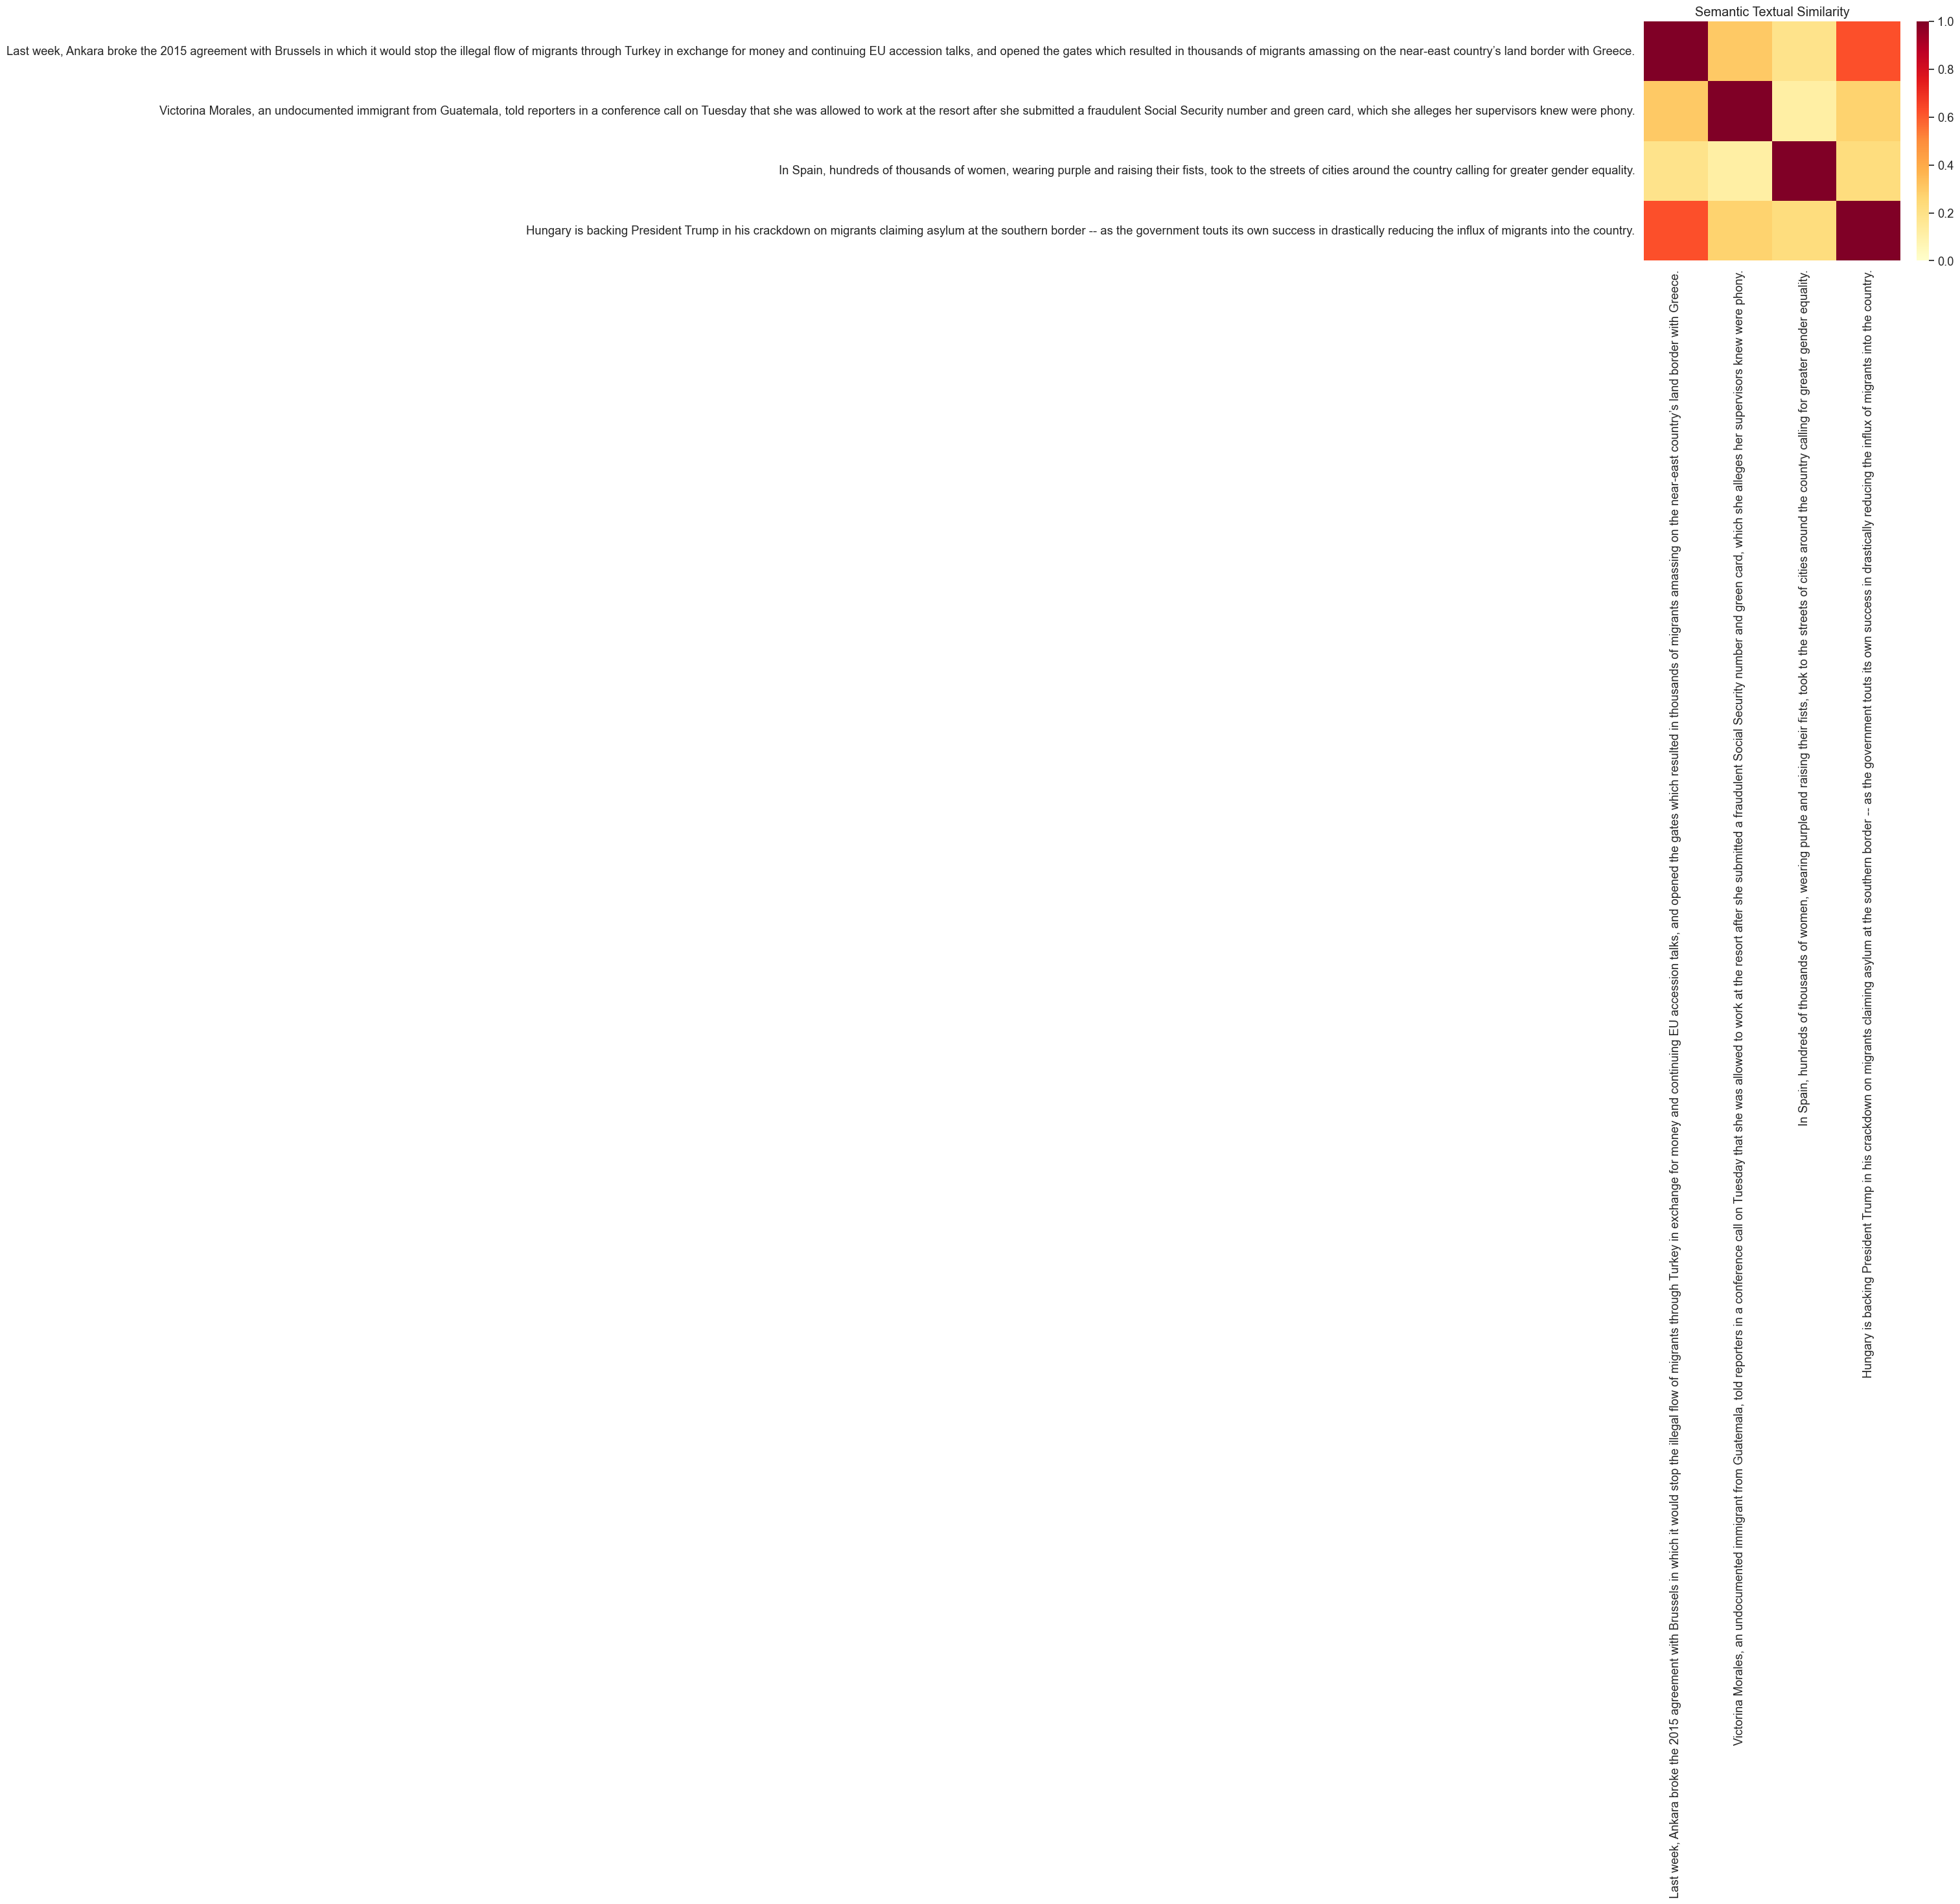

In [19]:
messages = [sentence, sentence_2, sentence_3, sentence_4]

run_and_plot(messages)